## Titanic Survival Analysis
This dataset contains demographics of 891 of the 2224 passengers and crew on board the Titanic. The data was obtained from [Kaggle](https://www.kaggle.com/c/titanic/data). 

This project analyzes the relationship between the survival likelihood of Titanic passengers and such demographic features as ticket class, age, number of siblings/spouses on board, number of parents children on board, ticket number, fare, carbin number, and port of embarkation. Finally, a logistic regression model will be used to predict the survival of the passengers using these features.

A detailed list of the variables is as follows:

|Variable |Definition                                  |Key                                             |
|:--------|:-------------------------------------------|:-----------------------------------------------|
|survival |Survival	                                   |0 = No, 1 = Yes                                 |
|pclass	  |Ticket class                                |1 = 1st, 2 = 2nd, 3 = 3rd                       |
|sex	  |Sex	                                       |                                                |
|Age	  |Age in years	                               |                                                |
|sibsp	  |# of siblings / spouses aboard the Titanic  |                                                |	
|parch	  |# of parents / children aboard the Titanic  |                                                |	
|ticket	  |Ticket number	                           |                                                |
|fare	  |Passenger fare	                           |                                                |
|cabin	  |Cabin number	                               |                                                |
|embarked |Port of Embarkation                         |C = Cherbourg, Q = Queenstown, S = Southampton  |

*(Variable Notes: pclass is a proxy for socio-economic status (SES). 1st = Upper, 2nd = Middle, 3rd = Lower)*

In [1]:
# First let's read in the necessary libraries for exploring and visuliazing the data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 

In [3]:
path = './train.csv'
titanic = pd.read_csv(path)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
titanic.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# Take a look at which variables have missing values.

titanic.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Results show that three variables including Age, Cabin, and Embarked have about 20%, 77%, and 0.2% missing values, respectively. However, for now I will move on with exploring the demographic features and come back to handel the missing values when I clean the data for modeling.

For the sake of simpicity, for now I'd like to bucketize the 'age' variable to able to easily visualize it's relationship with the survival rate.

In [6]:
# Create a new column 'age_group' by bucketizing ages into childen, adults, and elderly.

def age_group(data):
    """
    INPUT
        The age of the passengers
    
    OUTPUT
        Different age groups based on the age of the passenger
    """
    if data >= 65:
        return 'elderly'
    elif 16 <= data < 65:
        return 'adult'
    elif data < 16:
        return 'child'   
          
titanic['age_group'] = titanic['Age'].apply(age_group)

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult


In [34]:
# Create series containing the columns to save some typing. 

survival = titanic['Survived']
ticket_class = titanic['Pclass']
sex = titanic['Sex']
age = titanic['Age']
age_group = titanic['age_group']
siblings_spouses = titanic['SibSp']
parents_children = titanic['Parch']
embark_port = titanic['Embarked']

Now we can start asking some general questions about the data, such as how many of the 891 passengers survived, the age distribution among them, how many of them are in each of the three ticket classes et cetera.

In [27]:
# Were there more people who survived than those who didn't survive?

Counter(survival)

Counter({0: 549, 1: 342})

In [11]:
# How is the age distribution of the passengers?

age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [13]:
age.median()

28.0

In [19]:
# Most common age of the passenger.

age.value_counts().idxmax()

24.0

Text(0.5, 1.0, 'Age distribution of the passengers')

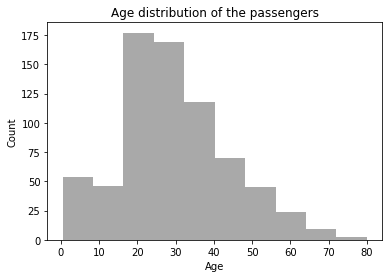

In [24]:
# Histogram of the age distribution.

age.plot.hist(color='darkgrey')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution of the passengers')

In [20]:
# Top 20 most common ages of the passenger.

Counter(age).most_common(20)

[(24.0, 30),
 (22.0, 27),
 (18.0, 26),
 (28.0, 25),
 (19.0, 25),
 (30.0, 25),
 (21.0, 24),
 (25.0, 23),
 (36.0, 22),
 (29.0, 20),
 (26.0, 18),
 (35.0, 18),
 (27.0, 18),
 (32.0, 18),
 (31.0, 17),
 (16.0, 17),
 (20.0, 15),
 (34.0, 15),
 (33.0, 15),
 (23.0, 15)]

In [28]:
# How many passengers were in each age group?

Counter(age_group)

Counter({'adult': 620, None: 177, 'child': 83, 'elderly': 11})

In [30]:
# How many people embarked from each of the three ports?

Counter(embark_port)

Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})

In [32]:
# Sex distribution among passengers and different classes

Counter(sex)

Counter({'male': 577, 'female': 314})

In [37]:
# Were there more people taking the 3rd class?

Counter(ticket_class)

Counter({3: 491, 1: 216, 2: 184})

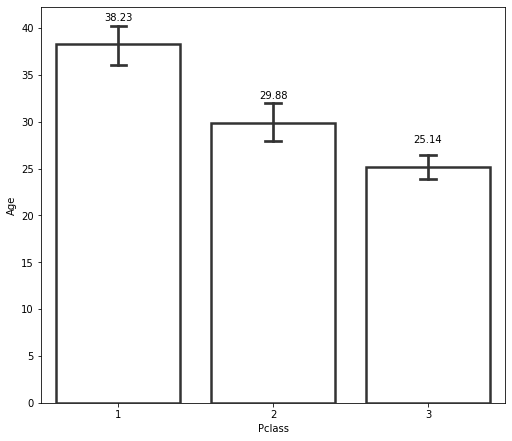

In [35]:
# How about the distribution of age and classes in relation to each other?

ax = sns.barplot(y=age, x=ticket_class, capsize=0.1, linewidth=2.5, \
                 facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
plt.subplots_adjust(top=1.5,right=1.2)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., 
            height + 2.6,
            '{:1.2f}'.format(height),
            ha="center")

In [36]:
titanic.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

The mean ages in the first and second classes were higher than in the third class.

In [40]:
titanic.groupby(['Pclass', 'age_group'])['Survived'].mean()

Pclass  age_group
1       adult        0.666667
        child        0.833333
        elderly      0.166667
2       adult        0.421053
        child        1.000000
        elderly      0.000000
3       adult        0.204082
        child        0.431034
        elderly      0.000000
Name: Survived, dtype: float64

In [42]:
# To get a rough idea of how the survival likelihood is related to the demographic factors

def barplot(factor):
    return sns.barplot(x=titanic[factor], y=survival, ci=95, capsize=.1, \
            linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor='.2', edgecolor='.2')

def lineplot(factor):
    return sns.lineplot(x=titanic[factor], y=survival, color='black')

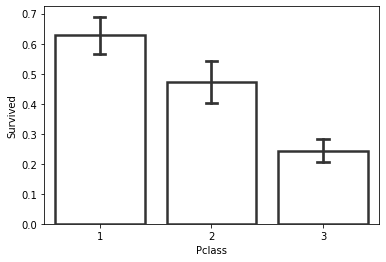

In [43]:
barplot('Pclass')

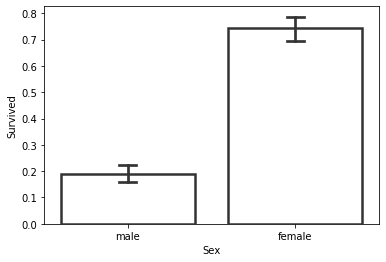

In [44]:
barplot('Sex')

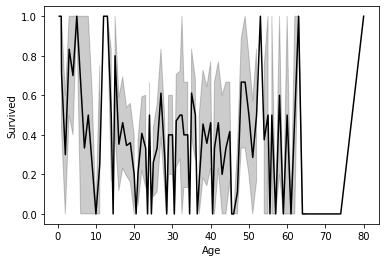

In [45]:
lineplot('Age')

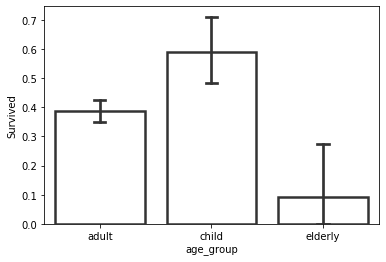

In [46]:
barplot('age_group')

So far it looks like variables including ticket class, sex, and age showed some correlations to the sruvival rate. 

Now that we are quite confident that age, sex, and ticket class have correlations to the survival rate, we can move on and take a look at other variables.

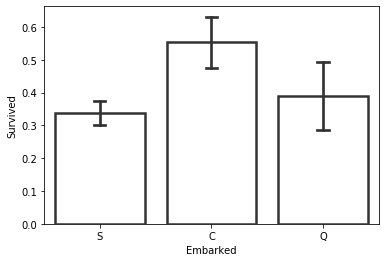

In [69]:
barplot('Embarked')

It looks like embarking port also has some correlation to the survival rate, but it's not clear at the moment. However, we shall consider this variable when fitting the model.

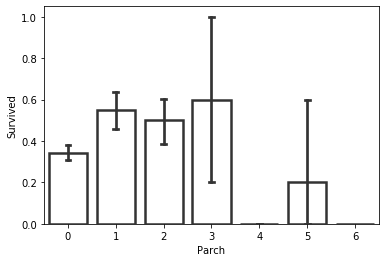

In [68]:
barplot('Parch')

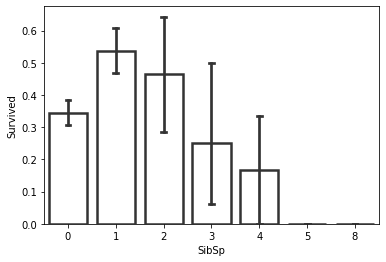

In [67]:
barplot('SibSp')

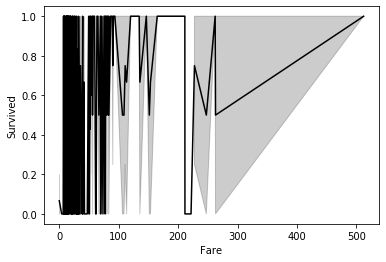

In [70]:
lineplot('Fare')

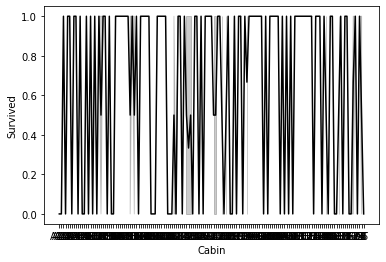

In [71]:
lineplot('Cabin')

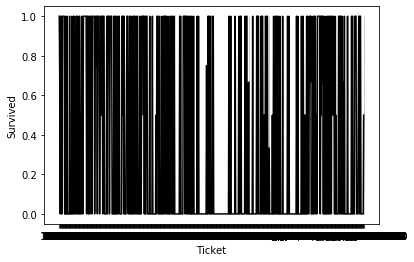

In [72]:
lineplot('Ticket')

Based on the plots I decide that fare, cabin number, and ticket number didn't seem to have a relationship with survival, so I will only go on with analyzing other factors. 

In [73]:
# Calculate Pearson's correlation r between these factors and the survival when applicabl

def correlation(variable1, variable2):
    
    standardized_variable1 = (variable1 - variable1.mean()) / variable1.std()
    standardized_variable2 = (variable2 - variable2.mean()) / variable2.std()
    
    r = (standardized_variable1 * standardized_variable2).mean()
    
    return r

In [74]:
correlation(ticket_class, survival)

-0.3381011470317661

In [75]:
correlation(age, survival)

-0.0778843066160926

In [77]:
correlation(siblings_spouses, survival)

-0.03528285522817583

In [78]:
correlation(parents_children, survival)

0.08153779158731796

At this point, based on the findings from the previous data explorations, I can draw some tentative conclusions before applying machine learning for predicting the survival likelihood.

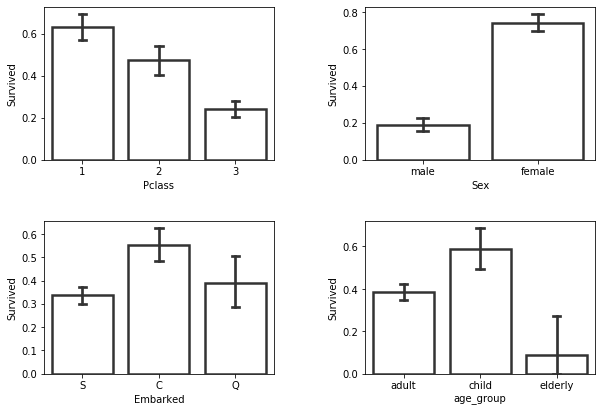

In [79]:
# At this point, I can draw some tentative findings before applying machine learning for prediction

fig, axis=plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4,  top=1.4,right=1.4)
sns.barplot(y=survival, x=ticket_class, ax=axis[0,0], capsize=.1, \
            linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
sns.barplot(y=survival, x=sex, ax=axis[0,1], capsize=.1, \
            linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
sns.barplot(y=survival, x=embark_port, ax=axis[1,0], capsize=.1, \
            linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
sns.barplot(y=survival, x=age_group, ax=axis[1,1], capsize=.1, \
            linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')

In addition, we can also group some factors together to see how the survival rate varies within different groups.

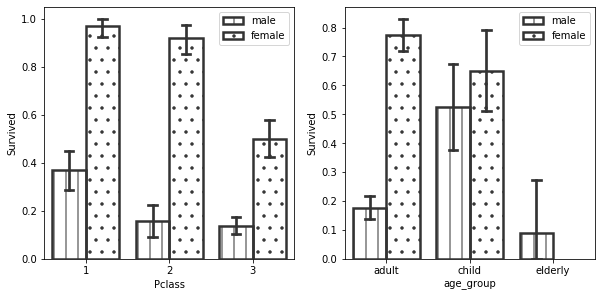

In [80]:
fig, axis = plt.subplots(nrows=1, ncols=2, sharey=False)
plt.subplots_adjust(wspace=0.2, top=1.0,right=1.4)

ax1 = sns.barplot(x=ticket_class, y=survival, hue=sex, capsize=.1, \
                  ax=axis[0], linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
hatches = ['|', '|', '|', '.', '.', '.']
# Loop over the bars
for i,thisbar in enumerate(ax1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
ax1.legend(loc='upper right')

ax2 = sns.barplot(x=age_group, y=survival, hue=sex, ax=axis[1], capsize=.1, \
                linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor='.2')
hatches = ['|', '|', '|', '.', '.', '.']
# Loop over the bars
for i,thisbar in enumerate(ax2.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
ax2.legend(loc='upper right')

### Some findings so far and tentative conclusions we can draw from the data exploration phase 
1. Among the 891 passengers analyzed, 342 of them survived (38.4%).

2. Mean age is 29.7 years old, minimum and maximum ages are 0.42 and 80, respectively. 

3. Most frequent age is 24 years old (30 passengers), while top 20 most frequent ages are within 16-36 years old, accounting for 46.4% of the passengaers.

4. There were more passengers in the 3rd class (491, 55%) than in the 1st class(214) and 2rd class(184).

5. Most people (about 72%) embarked on the ship from port S (Southampton). 

6. Passengers with the following features seem to have more likelihood to survive: being in the 1st class (r=-0.34), being female, having embarked at port C(Cherbourg), and being 16 or younger.

7. On the other hand, numbers of siblings and spouses (r=-0.04) as well as parents and children (r=0.08) did not seem to have a strong relationship with survival.
 